## probit model analysis continued
### subwise parameter estimates
subise estimates for `format` modelled
1. together
2. separate
    * RNP ~ stake size SLOPE subwise-MAPs
    * check subwise params correlation across format (modelled separately - model 2)

In [42]:
# behav_fit2_clone ?! behav_fit not

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi
import arviz as az

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')
plot_folder = op.join(bids_folder, 'plots_and_ims', 'behavior_risk')
save_params_folder = op.join(bids_folder,'derivatives/phenotype')

from utils import get_data
import numpy as np
           
df = get_data()
df['x'] = df['log(risky/safe)'] 

group_list = df.reset_index().drop_duplicates(subset=['subject', 'group'])[['subject', 'group']].set_index('subject')

#group_mapping = df.reset_index()[['subject', 'group']].drop_duplicates().set_index('subject').sort_index()


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [7]:
model_label = 1
format = 'both'
data = df.copy()

model = bambi.Model('chose_risky ~ x + x*group*format + (x*format|subject)', link='probit', family='bernoulli', data=data.reset_index())
traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))

In [5]:
model_label = 4
format = 'symbolic'

data = df.xs(format, 0, level='format')
model = bambi.Model('chose_risky ~ x + x*group*C(n_safe) + (x*C(n_safe)|subject)', link='probit', family='bernoulli', data=data.reset_index())
traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))

### Subwise posteriors for both formats modelled together

In [3]:
from utils import extract_rnp_precision

intercept, gamma = extract_rnp_precision(traces, model, data, format=True, group_level = False)# 
rnp = np.clip(np.exp(intercept/gamma), 0, 1)


/Users/mrenke/mambaforge/envs/behav_fit2_copy/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [15]:
rnps = rnp.stack([1, 2]).groupby(['subject','format']).mean().rename(mapper={'chose_risky_mean':'rnp'},axis=1)
gammas = gamma.stack([1, 2]).groupby(['subject','format']).mean().rename(mapper={'chose_risky_mean':'gamma'},axis=1)
intercepts = intercept.stack([1, 2]).groupby(['subject','format']).mean().rename(mapper={'chose_risky_mean':'intercept'},axis=1)

params = gammas.join(rnps).join(intercepts)
params.to_csv(op.join(save_params_folder,f'risk_all-params_probit-{model_label}_format-{format}.csv'))

In [ ]:
intercept_ = intercept.stack([1, 2]).groupby(['subject', 'format']).mean()
intercept_.columns = ['intercept']

sns.lmplot(intercept_.unstack('format').droplevel(0,axis=1), x='non-symbolic', y='symbolic')

### Subwise posteriors for formats modelled seperate

#### Stake Size - RNP effect for single subjects

In [2]:
model_label = 2
format = 'symbolic'
data = df.xs(format, 0, level='format')
model = bambi.Model('chose_risky ~ x + x*group*n_safe + (x*n_safe|subject)', link='probit', family='bernoulli', data=data.reset_index())
traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))


In [3]:
from utils import extract_rnp_precision

intercept, gamma = extract_rnp_precision(traces, model, data, format=False, group_level = False)# 
rnp = np.clip(np.exp(intercept/gamma), 0, 1)


/Users/mrenke/mambaforge/envs/behav_fit2_copy/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [4]:
rnp = rnp.stack([1,2])
rnp.columns = ['rnp']
rnp.head()

rnp
subject n_safe group chain draw          
13      7.0    1     0     0     0.317655
                           1     0.298468
                           2     0.276213
                           3     0.321910
                           4     0.239726

In [ ]:
from itertools import product

n_chains = rnp.index.unique('chain').values
n_draws = rnp.index.unique('draw').values
subjects = rnp.index.unique('subject').values

index = pd.MultiIndex.from_product([subjects, n_chains, n_draws ], names=['subject','chain', 'draw'])
df_ss = pd.DataFrame(index=index, columns=['slope', 'intercept'])

for chain, draw in product(n_chains, n_draws):
    rnp_sample = rnp.xs(chain, level='chain').xs(draw, level='draw').reset_index('n_safe')

    for sub in subjects:
        group = group_list.loc[sub].values[0] # # only sample from appropriate group for respective subject
        tmp = rnp_sample.xs([sub, group], level=['subject', 'group']) 
        tmp = rnp_sample.xs(sub,0,level='subject') #

        A = np.vstack([tmp['n_safe'], np.ones(len(tmp))]).T
        slope, intercept = np.linalg.lstsq(A, tmp['rnp'], rcond=None)[0]
        df_ss.loc[(sub, chain, draw), 'slope'] = slope
        df_ss.loc[(sub, chain, draw), 'intercept'] = intercept
# takes 6 minutes

# save MAPs
df_ss.groupby('subject').mean().to_csv(op.join(save_params_folder, f'risk_SS-RNP-subwise-MAPs_probit-{model_label}_format-{format}.csv'))
#df_ss.to_csv(op.join(save_params_folder, f'risk_SS-RNP-subwise-Samples_probit-{model_label}_format-{format}.csv'))

Text(0.5, 1.0, 'RNP~Stake-Size Slope')

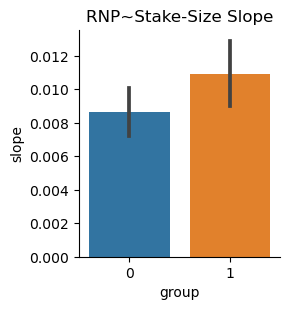

In [53]:
tmp = df_ss.join(group_list).set_index('group',append=True).groupby(['subject','group']).mean()
tmp.head()
sns.catplot(data=tmp.reset_index(), x='group', y='slope', kind='bar',height=3, aspect=1)
plt.title('RNP~Stake-Size Slope')

### check subwise params correlation across format (modelled separately)

In [9]:
from utils import extract_rnp_precision

model_label = 2
formula = 'chose_risky ~ x + x*group*n_safe + (x*n_safe|subject)'

In [10]:
format = 'symbolic'
data = df.xs(format, 0, level='format')
model = bambi.Model(formula, link='probit', family='bernoulli', data=data.reset_index())
traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))

intercept_symb, gamma_symb = extract_rnp_precision(traces, model, data, format=False, group_level = False)
intercept_symb = intercept_symb.stack([1, 2]).groupby(['subject']).mean()
intercept_symb.columns = ['intercept_nonsymb']
gamma_symb = gamma_symb.stack([1, 2]).groupby(['subject']).mean()
gamma_symb.columns = ['gamma_nonsymb']

In [26]:
model_label = 2
format = 'non-symbolic'

data = df.xs(format, 0, level='format')
model = bambi.Model('chose_risky ~ x + x*group*n_safe + (x*n_safe|subject)', link='probit', family='bernoulli', data=data.reset_index())
traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))

intercept_nonsymb, gamma_nonsymb = extract_rnp_precision(traces, model, data, format=False, group_level = False)
intercept_nonsymb = intercept_nonsymb.stack([1, 2]).groupby(['subject']).mean()
intercept_nonsymb.columns = ['intercept_symb']
gamma_nonsymb = gamma_nonsymb.stack([1, 2]).groupby(['subject']).mean()
gamma_nonsymb.columns = ['gamma_symb']


In [13]:
df_comb = pd.concat([intercept_symb, gamma_symb, intercept_nonsymb, gamma_nonsymb], axis=1).join(group_list.set_index('subject'))
df_comb.head()
df_comb

,intercept_nonsymb,gamma_nonsymb,intercept_symb,gamma_symb,group
subject,,,,,
1,-4.374759,4.376777,-3.331400,2.534211,0
2,-3.017098,2.493483,-3.277667,2.672098,1
3,-3.446032,1.841914,-2.426703,1.628224,0
4,-4.312870,3.754582,-3.158825,3.128450,1
5,-2.852336,3.111328,-1.916037,1.950272,0


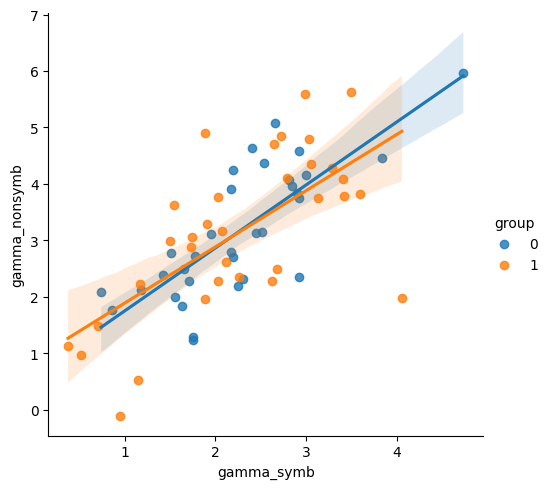

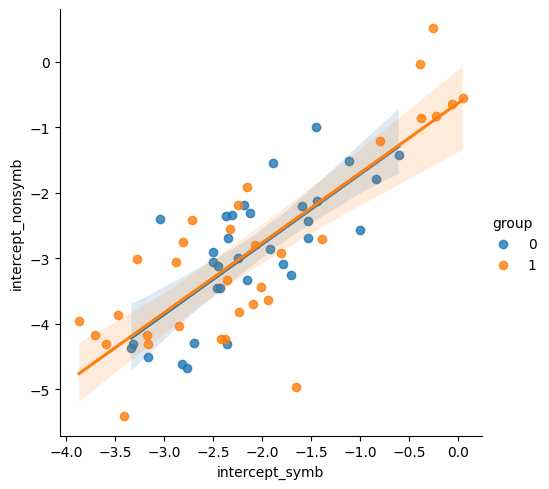

In [22]:
param = 'gamma' 
sns.lmplot(data=df_comb.reset_index(), x=f'{param}_symb',y=f'{param}_nonsymb', hue='group')
param = 'intercept' 
sns.lmplot(data=df_comb.reset_index(), x=f'{param}_symb',y=f'{param}_nonsymb', hue='group')


In [ ]:
g = gamma.stack([1, 2])
g.columns = ['gamma']

fac = sns.catplot(x='subject', y='gamma', data=g.reset_index(), aspect=5., kind='violin', hue='format')
fac.set(title='Risk', ylabel='gamma')
fac.add_legend()

In [ ]:
# RNP
for i, group in enumerate(['control','dyscalculic']):
    plt.figure()
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = rnp[rnp.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='rnp', data=temp.reset_index(), hue='format', aspect=5., kind='violin')
    plt.ylim(0, 1)
    plt.axhline(.55, c='k', ls='--', label='risk-neutral')
    fac.set(title=f'{group}', ylabel='Risk neutral probability')
    fac.add_legend()

In [ ]:
subList_remove = [32,40,45,46,50]#[1,2,3,4,5] #[6,7,8,9,10] #  
gamma_fil = gamma.loc[gamma.index.get_level_values('subject').isin(subList_remove)] 
sns.violinplot(data=gamma_fil.reset_index(), x='subject',y='gamma',hue='n_safe')
plt.ylim(-2,8)

In [ ]:
subList_remove = [32,40,45,46,50]# [6,7,8,9,10] # 
intercept_fil = intercept.loc[intercept.index.get_level_values('subject').isin(subList_remove)] 
sns.violinplot(data=intercept_fil.reset_index(), x='subject',y='intercept',hue='n_safe')
plt.ylim(-8,0)